# **1- Importing necessary packages**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
import os
import math
import numpy as np
from tensorflow import keras
#from keras.preprocessing.sequence import TimeSeriesGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
#from Ipython.display import clear_output
import tensorflow.compat.v2.feature_column as fc
from tensorflow.keras.utils import plot_model
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **2- Importing the training set and validation set for electricity or heating demand**

In [ ]:
from google.colab import files
uploaded = files.upload() # u can now upload the datasetst

In [ ]:
import io
X_train_electricity=pd.read_csv(io.BytesIO(uploaded["X_train_electricity.csv"]))   # import the training dataset that is preprocessed by the data_prepration pipeline 
Y_train_electricity=pd.read_csv(io.BytesIO(uploaded["X_train_electricity.csv"])) 

X_test_electricity=pd.read_csv(io.BytesIO(uploaded["X_test_electricity.csv"]))    # import the test dataset.
Y_test_electricity=pd.read_csv(io.BytesIO(uploaded["Y_test_electricity.csv"])) 

# **3- Creating a function to define mini-batch size and epoch numbers**

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=5600):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(48)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into 10 mini-batches, each of size 5600 (70080*0.8/10), and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

Train_input_fn = make_input_fn(X_train_electricity, Y_train_electricity)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
Eval_input_fn = make_input_fn(X_test_electricity, Y_test_electricity, num_epochs=1, shuffle=False)

# **4- Creating a function to define feature columns**


In [ ]:
# Feature columns describe how to use the input.
def my_feature_columns (data_df):
  my_feature_columns = []
  for key in data_df.keys():
      my_feature_columns.append(tf.feature_column.numeric_column(key=key))
  print(my_feature_columns)

# **5- Creating the model (Construction phase)**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# **S-DRNN_2LSTM**

**Comments for creating the final model**


1.   The initial LSTM layer requires a specification of its input_shape. To correctly specify this, follow this simple rule: take the X_train.shape: (1847, 90, 1), drop the first dimension: (90, 1), there you have the correct input_shape. It's as easy as that.
2.  For Deep RNNs, each LSTM() that is not the last requires return_sequences = True. That is because an LSTM layer that is not outputting to Dense() layers must receive a series of data to be processed, so you want other layers to return a sequence of data of a kind similar to your input. 
*   Dense() layer has the same size of the previous LSTMs output sequence. This intermediate layer fires to the output layer, that has a number of nodes equal to the number of forecast steps. Regression tasks require no activation function at the output layer, since no activation means linear activation.









In [ ]:
lstm1 = tf.keras.layers.LSTM(    input_shape=(9,1),units=400, activation='tanh',
                                recurrent_activation='sigmoid', use_bias=True, dropout=0.0, return_sequences=True
                                                                                   )   

In [ ]:
lstm2 = tf.keras.layers.LSTM(    units=400, activation='tanh',
                                recurrent_activation='sigmoid', use_bias=True, dropout=0.0, return_sequences=False
                                                                                   )   

Model: "S-DRNN_2LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9, 1)]            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 9, 400)            643200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1281600   
Total params: 1,924,800
Trainable params: 1,924,800
Non-trainable params: 0
_________________________________________________________________


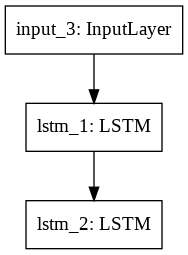

In [ ]:
inputs = keras.Input(shape=(9,1))
x0=lstm1(inputs)     
x1 = lstm2(x0)
S_model = keras.Model(inputs=inputs, outputs=x1, name="S-DRNN_2LSTM")
S_model.summary()
plot_model(S_model, to_file="S_model_2LSTM.png")

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError()
S_model.compile( optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                loss="mean_squared_error",
                metrics=[rmse])

In [ ]:
EPOCHS= 10
history = S_model.fit(X_train_electricity, Y_train_electricity,
                   validation_data=(X_test_electricity, Y_test_electricity),
                   epochs=EPOCHS,
                  batch_size=5600, # you can use the make_input_fn as well.
                  callbacks=[tfdocs.modeling.EpochDots()])

# **Plot some Results**

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
epoch = hist["epoch"]
RMSE_training = hist["root_mean_squared_error"]
RMSE_validation= hist["val_root_mean_squared_error"]
hist.tail()

In [ ]:
plt.title("Training and validation errors")
plt.plot(epoch, RMSE_training, color="orange", label="Train")
plt.plot(epoch, RMSE_validation, color="blue", label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Errors")
plt.legend()


# **To distribute the calculation between multiple GPUs**

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  model = Final_model= tf.keras.Model(inputs=[Train_input_fn], outputs=[Eval_input_fn])
  Final_model.compile(model)
  Final_mode.fit()